# Sea Surface Temperature: Exploratory Analysis

In [95]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from matplotlib import pyplot as plt
from netCDF4 import Dataset

import cartopy
import cartopy.crs as ccrs

ABS_ZERO = -273.15

In [96]:
# NOT ACTUALLY DAILY!!!!

si_ssts = xr.open_dataset('../SST_data/Historical/si_sst.nc', engine="netcdf4")
sp_ssts = xr.open_dataset('../SST_data/Historical/sp_sst.nc', engine="netcdf4")

# latitude was indexed the wrong way
si_ssts = si_ssts.reindex(latitude=list(reversed(si_ssts.latitude)))
sp_ssts = sp_ssts.reindex(latitude=list(reversed(sp_ssts.latitude)))

# convert to degrees celsius for readability
si_ssts = si_ssts.map(lambda x: x + ABS_ZERO)
sp_ssts = sp_ssts.map(lambda x: x + ABS_ZERO)

# use ERA5 instead of ERA5T (former is the one that is validated)
si_ssts = si_ssts.sel(expver=1).dropna('time', 'all')
sp_ssts = sp_ssts.sel(expver=1).dropna('time', 'all')



In [97]:
si_ssts

<xarray.Dataset>
Dimensions:    (longitude: 421, latitude: 201, time: 2032)
Coordinates:
  * longitude  (longitude) float32 30.0 30.25 30.5 30.75 ... 134.5 134.8 135.0
  * latitude   (latitude) float32 -50.0 -49.75 -49.5 -49.25 ... -0.5 -0.25 0.0
    expver     int32 1
  * time       (time) datetime64[ns] 1979-01-01 ... 2021-04-01T18:00:00
Data variables:
    sst        (time, latitude, longitude) float32 3.399 3.205 ... 29.71 29.72

In [98]:
si_ssts['time']

<xarray.DataArray 'time' (time: 2032)>
array(['1979-01-01T00:00:00.000000000', '1979-01-01T06:00:00.000000000',
       '1979-01-01T12:00:00.000000000', ..., '2021-04-01T06:00:00.000000000',
       '2021-04-01T12:00:00.000000000', '2021-04-01T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    expver   int32 1
  * time     (time) datetime64[ns] 1979-01-01 ... 2021-04-01T18:00:00
Attributes:
    long_name:  time

In [99]:
sp_ssts

<xarray.Dataset>
Dimensions:    (longitude: 181, latitude: 201, time: 2032)
Coordinates:
  * longitude  (longitude) float32 135.0 135.2 135.5 135.8 ... 179.5 179.8 180.0
  * latitude   (latitude) float32 -50.0 -49.75 -49.5 -49.25 ... -0.5 -0.25 0.0
    expver     int32 1
  * time       (time) datetime64[ns] 1979-01-01 ... 2021-04-01T18:00:00
Data variables:
    sst        (time, latitude, longitude) float32 8.238 8.268 ... 28.06 28.06

[Text(0.5, 1.0, 'Mean SST since 1979')]

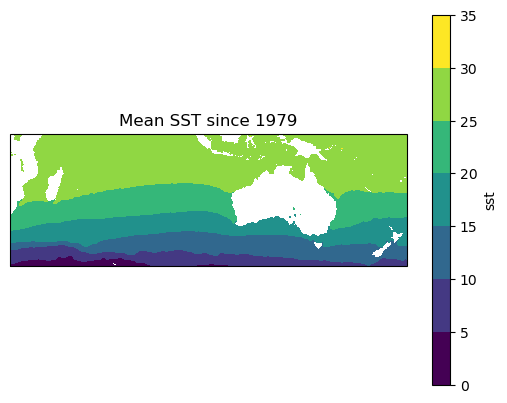

In [100]:
projection = ccrs.Mercator()
crs = ccrs.PlateCarree()

# NOTE: because of the apparent significance of ENSO, 
#       it would be good to have temperature data extending all the way 
#       over to the American coast

ax = plt.axes(projection=projection, frameon=True)
merged = xr.combine_by_coords([si_ssts, sp_ssts])
merged['sst'].mean('time').plot.contourf(ax=ax)
ax.set(title = "Mean SST since 1979")

/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[Text(0.5, 1.0, 'Standard Deviation of SST')]

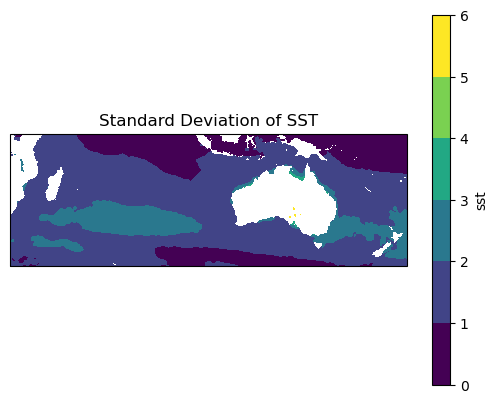

In [101]:
ax = plt.axes(projection=projection, frameon=True)
merged['sst'].std('time').plot.contourf(ax=ax)
ax.set(title="Standard Deviation of SST")

### A note
We only have 2040 time indices in these datasets. The time index seems to be 
<b>four observations for the first of each month</b>. Hence, we only have observations 
for <b>twelve days each year</b>

### Remark
Should we potentially sacrifice some of our spatial resolution to get data at more timepoints?

In [102]:
# df = si_ssts.sel(latitude=slice(-15, 0), longitude=slice(60, 130), time=si_ssts.time.dt.hour.isin([6, 18]))['sst'].to_dataframe()
# df['sst'].loc[:, 'time']



## What has been the trend of SST in our oceans?

In [103]:
# It is too computationally demanding to create a big old region so I will split it up into 
# little chunks around areas of interest in different regions of the two ocean basins

# look at squares of size 5 degrees
square_size = 5 

# TODO: Show these regions on a map

si_locales = [
    {"longitude": 55.601746, "latitude": -3.764745, "name": "Seychelles" },   
    {"longitude": 56.47, "latitude": -20.45, "name": "Mauritius and Reunion"},
    {"longitude": 73.108510, "latitude": -3.787101, "name": "Maldives"},    
#     {"longitude": 104.677851, "latitude": -6.608402}, # west coast of Java -- this one didnt have data
    {"longitude": 126.852503, "latitude": -11.057182, "name": "Timor Sea"}  
]

sp_locales = [
    {"latitude":-21.200637, "longitude": 165.362454, "name": "New Caledonia"}, 
    {"latitude": -16.679548, "longitude": 178.579560, "name": "Fiji"}, 
    {"latitude": -17.047411, "longitude": 168.174452, "name": "Vanuatu"}, 
    {"latitude":-34.289968, "longitude": 172.854628, "name": "North NZ"},
    {"latitude": -8.473541, "longitude": 158.967909, "name": "Solomon Islands"}  
]
    

si_locales_ssts = [si_ssts.sel(
    latitude=  slice(locale["latitude"]  - square_size/2, locale["latitude"]  + square_size/2), 
    longitude= slice(locale["longitude"] - square_size/2, locale["longitude"] + square_size/2)
) for locale in si_locales]

sp_locales_ssts = [sp_ssts.sel(
    latitude=  slice(locale["latitude"]  - square_size/2, locale["latitude"]  + square_size/2), 
    longitude= slice(locale["longitude"] - square_size/2, locale["longitude"] + square_size/2)
) for locale in sp_locales]



Here, I seek to check the evolution of yearly mean SSTs in these areas of interest.

In [104]:
si_dfs = []
sp_dfs = []
for locale_ssts in si_locales_ssts:

    # convert to a dataframe for plotting....
    df = locale_ssts.resample(time='1Y').mean('time').to_dataframe()
    si_dfs.append(df[~df.index.duplicated()])

for locale_ssts in sp_locales_ssts:

    # convert to a dataframe for plotting....
    df = locale_ssts.resample(time='1Y').mean('time').to_dataframe()
    sp_dfs.append(df[~df.index.duplicated()])

    



In [105]:
si_dfs

[                               expver        sst
 longitude latitude time                         
 53.25     -6.25    1979-12-31       1  27.741083
                    1980-12-31       1  27.772242
                    1981-12-31       1  27.676628
                    1982-12-31       1  28.097816
                    1983-12-31       1  28.106356
 ...                               ...        ...
 58.00     -1.50    2017-12-31       1  28.919373
                    2018-12-31       1  28.513529
                    2019-12-31       1  29.240332
                    2020-12-31       1  29.320150
                    2021-12-31       1  29.125854
 
 [17200 rows x 2 columns],
                                expver        sst
 longitude latitude time                         
 54.00     -22.75   1979-12-31       1  25.554415
                    1980-12-31       1  25.384911
                    1981-12-31       1  25.508902
                    1982-12-31       1  25.254044
                    1

### South Indian Locales

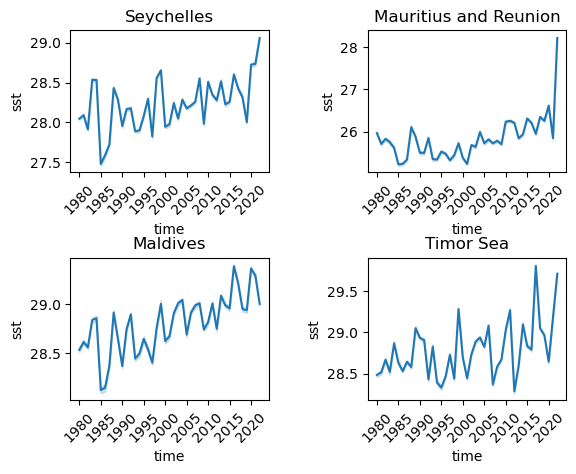

In [106]:
import matplotlib.ticker as ticker


fig = plt.figure()
fig.subplots_adjust(hspace=.6, wspace=.5)
num_plots = len(si_dfs)
for i in range(num_plots):
    ax = fig.add_subplot(2, int(num_plots/2), i+1)
    g = sns.lineplot(data=si_dfs[i], x='time', y='sst', ax=ax).set(title=si_locales[i]["name"])
    plt.xticks(rotation=45)


plt.show()

### South Pacific Locales

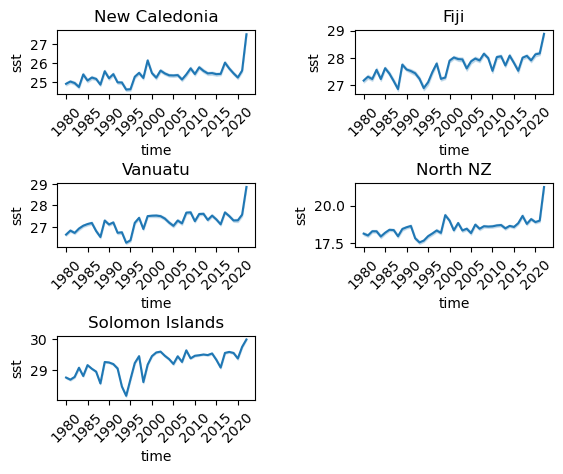

In [107]:
fig = plt.figure()
fig.subplots_adjust(hspace=1.4, wspace=.5)
num_plots = len(sp_dfs)
for i in range(num_plots):
    ax = fig.add_subplot(3, int(num_plots/3) + 1, i+1)
    g = sns.lineplot(data=sp_dfs[i], x='time', y='sst', ax=ax).set(title=sp_locales[i]["name"])
    plt.xticks(rotation=45)


plt.show()

### Where has warming been the worst?

In [108]:
# Create data variable 
# HOW TO ELIMINATE NOISE FROM THIS???
# Wish to get the first one s.t it's not null??
si_mean_ssts =  si_ssts.resample(time='1Y').mean('time')
si_init = si_mean_ssts.sel(time=si_mean_ssts.time.dt.year < 1984)
si_init_mean = si_init.mean('time')

# Create data variable 
# HOW TO ELIMINATE NOISE FROM THIS???
# Wish to get the first one s.t it's not null??
sp_mean_ssts =  sp_ssts.resample(time='1Y').mean('time')
sp_init = sp_mean_ssts.sel(time=sp_mean_ssts.time.dt.year < 1984)
sp_init_mean = sp_init.mean('time')

[si_init, sp_init]


[<xarray.Dataset>
 Dimensions:    (longitude: 421, latitude: 201, time: 5)
 Coordinates:
   * longitude  (longitude) float32 30.0 30.25 30.5 30.75 ... 134.5 134.8 135.0
   * latitude   (latitude) float32 -50.0 -49.75 -49.5 -49.25 ... -0.5 -0.25 0.0
     expver     int32 1
   * time       (time) datetime64[ns] 1979-12-31 1980-12-31 ... 1983-12-31
 Data variables:
     sst        (time, latitude, longitude) float32 3.243 3.269 ... 28.88 28.84,
 <xarray.Dataset>
 Dimensions:    (longitude: 181, latitude: 201, time: 5)
 Coordinates:
   * longitude  (longitude) float32 135.0 135.2 135.5 135.8 ... 179.5 179.8 180.0
   * latitude   (latitude) float32 -50.0 -49.75 -49.5 -49.25 ... -0.5 -0.25 0.0
     expver     int32 1
   * time       (time) datetime64[ns] 1979-12-31 1980-12-31 ... 1983-12-31
 Data variables:
     sst        (time, latitude, longitude) float32 7.309 7.33 ... 28.37 28.38]

In [109]:

# TODO: would be good to find a baseline using DISTANT HISTORICAL DATA 

si_with_deltas = si_ssts.assign(delta = si_ssts['sst'] - si_init_mean['sst'])
si_recent_deltas = si_with_deltas.sel(time= si_with_deltas.time.dt.year > 2016)
si_recent_delta_mean = si_recent_deltas.mean('time')

sp_with_deltas = sp_ssts.assign(delta = sp_ssts['sst'] - sp_init_mean['sst'])
sp_recent_deltas = sp_with_deltas.sel(time= sp_with_deltas.time.dt.year > 2016)
sp_recent_delta_mean = sp_recent_deltas.mean('time')

[si_recent_deltas, sp_recent_deltas]


[<xarray.Dataset>
 Dimensions:    (longitude: 421, latitude: 201, time: 208)
 Coordinates:
   * longitude  (longitude) float32 30.0 30.25 30.5 30.75 ... 134.5 134.8 135.0
   * latitude   (latitude) float32 -50.0 -49.75 -49.5 -49.25 ... -0.5 -0.25 0.0
     expver     int32 1
   * time       (time) datetime64[ns] 2017-01-01 ... 2021-04-01T18:00:00
 Data variables:
     sst        (time, latitude, longitude) float32 4.775 5.107 ... 29.71 29.72
     delta      (time, latitude, longitude) float32 1.017 1.281 ... 0.8065 0.8399,
 <xarray.Dataset>
 Dimensions:    (longitude: 181, latitude: 201, time: 208)
 Coordinates:
   * longitude  (longitude) float32 135.0 135.2 135.5 135.8 ... 179.5 179.8 180.0
   * latitude   (latitude) float32 -50.0 -49.75 -49.5 -49.25 ... -0.5 -0.25 0.0
     expver     int32 1
   * time       (time) datetime64[ns] 2017-01-01 ... 2021-04-01T18:00:00
 Data variables:
     sst        (time, latitude, longitude) float32 9.582 9.634 ... 28.06 28.06
     delta      (time, la

In [110]:
def round_to_half(x):
    return round(x*2)/2


max_level = (max(si_recent_delta_mean['delta'].max().item(), sp_recent_delta_mean['delta'].max().item()))
min_level = (min(si_recent_delta_mean['delta'].min().item(), sp_recent_delta_mean['delta'].min().item()))
max_abs = max(max_level, abs(min_level))
step_level = 0.5
contour_levels = np.arange(-round_to_half(max_abs), round_to_half(max_abs + step_level) , step_level)



### Heatmap of change in Indian Ocean sea surface temperatures

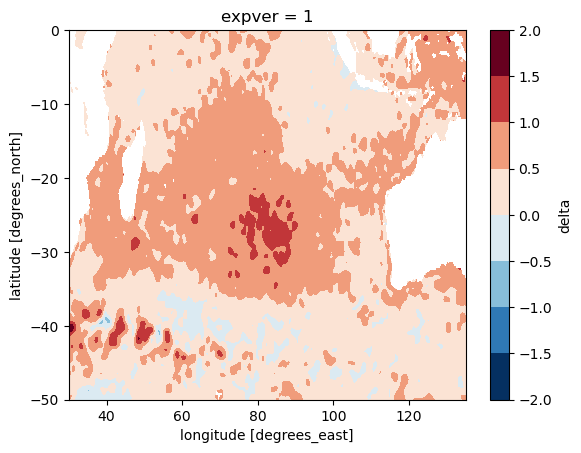

In [111]:
si_recent_delta_mean['delta'].plot.contourf(levels=contour_levels)

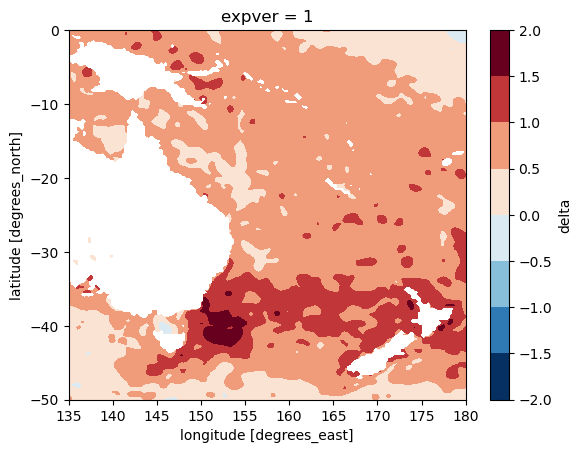

In [112]:
sp_recent_delta_mean['delta'].plot.contourf(levels=contour_levels)

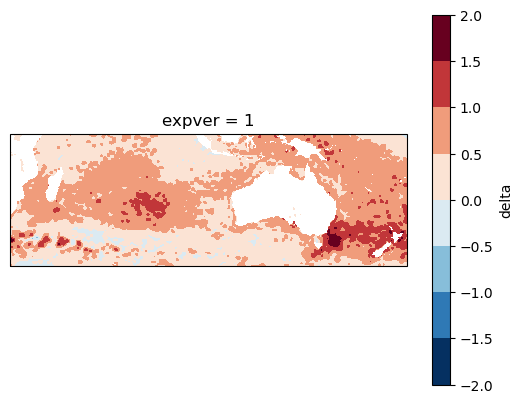

In [113]:
import cartopy.feature as cf

projection = ccrs.Mercator()
crs = ccrs.PlateCarree()

ax = plt.axes(projection=projection, frameon=True)
merged = xr.combine_by_coords([si_recent_delta_mean, sp_recent_delta_mean])
merged['delta'].plot.contourf(ax=ax, levels=contour_levels)